In [51]:
import pandas as pd
import numpy as np
from darts import TimeSeries
import config
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from darts.metrics import mase,ope,r2_score,mape
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel, TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing, TBATS, AutoARIMA, Theta

In [52]:
data_filename = 'count_dict.pickle'

In [53]:
count_dict = pd.read_pickle(config.DATA+'//data//'+data_filename)

In [54]:
df_item = count_dict['Ginger Tea']

## Resampling

In [55]:
df_item = df_item.resample('H', on='Order Placed Date_Time').sum()

In [56]:
df_item= df_item.loc['2021-11-24 08:00:00': '2022-08-31 23:59:00']

In [57]:
df_item['Total Count'].describe()

count    6736.000000
mean        0.610006
std         1.243632
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        15.000000
Name: Total Count, dtype: float64

In [58]:
df_item['Total Count'].value_counts()

0.0     4806
1.0      841
2.0      547
3.0      275
4.0      126
5.0       73
6.0       37
7.0       14
8.0        7
9.0        4
11.0       3
10.0       2
15.0       1
Name: Total Count, dtype: int64

In [59]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_item,freq='H',fill_missing_dates=True)
series2 = series.add_holidays('IN','KA')


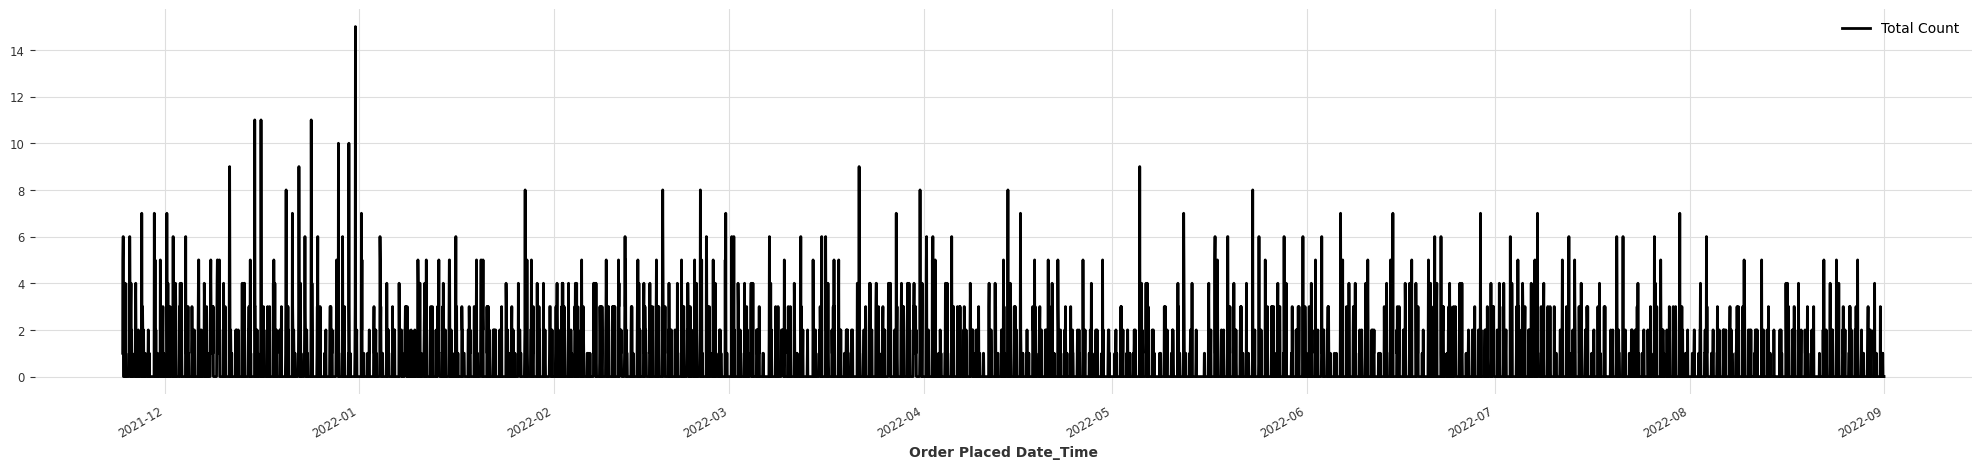

In [60]:
fig = plt.figure(figsize=(25,5))
series.plot()


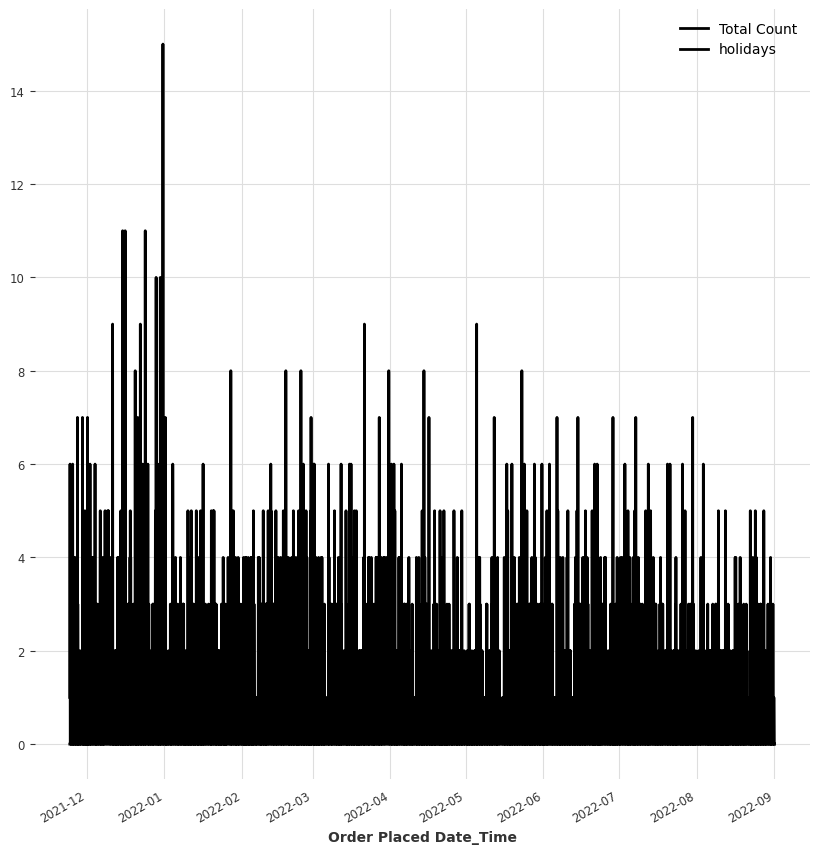

In [61]:
fig = plt.figure(figsize=(10,10))   
ax = fig.add_subplot()
series2.plot(linestyle = '-', color = 'black')


In [62]:
train, val = series.split_before(0.75)

Text(0, 0.5, 'Item Count')

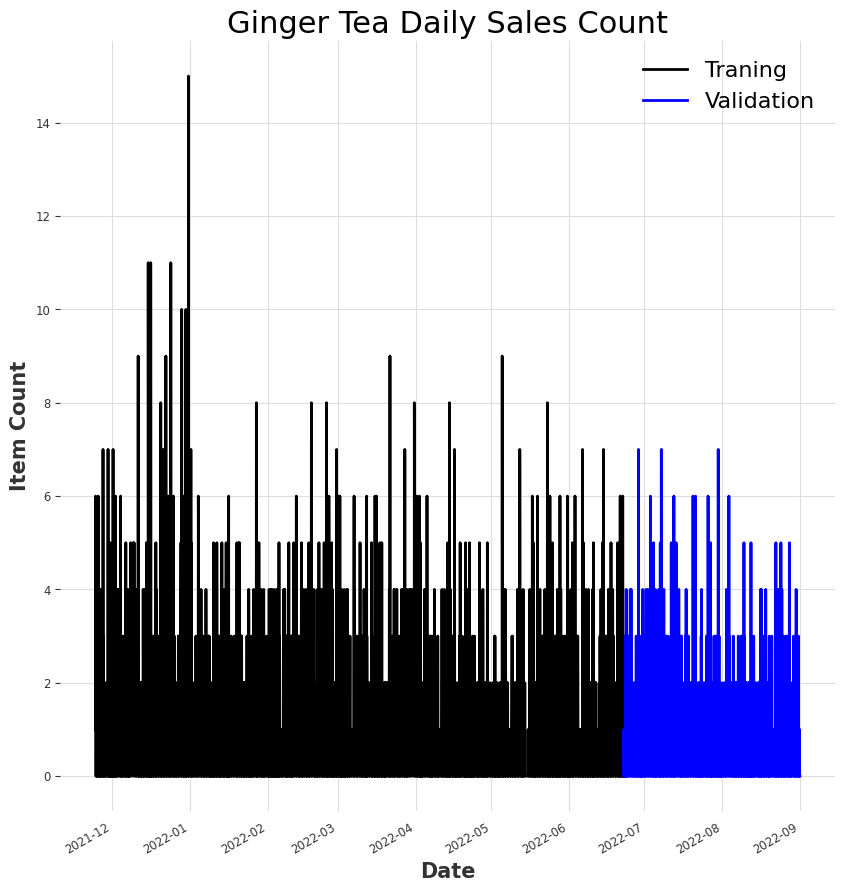

In [63]:
fig = plt.figure(figsize=(10,10))   
train.plot(linestyle = '-', color = 'black')
val.plot(linestyle = '-', color = 'blue')
plt.title('Ginger Tea Daily Sales Count',fontsize = 22)
plt.legend(loc=0, prop={'size': 16},labels= ['Traning','Validation','Holiday_train','Holiday_val'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)

## Naive Baseline Model

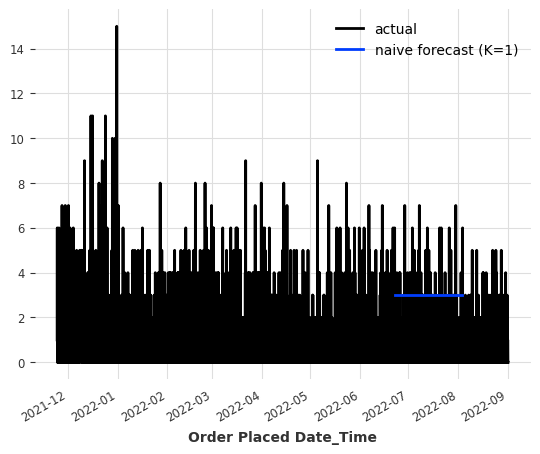

In [64]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(1000)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

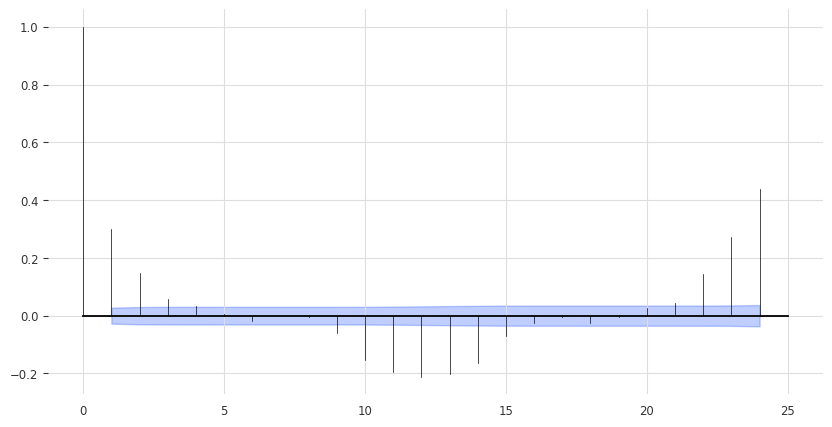

In [65]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=7, alpha=0.05)

In [66]:
for m in range(2, 12):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

Text(0, 0.5, 'Item Count')

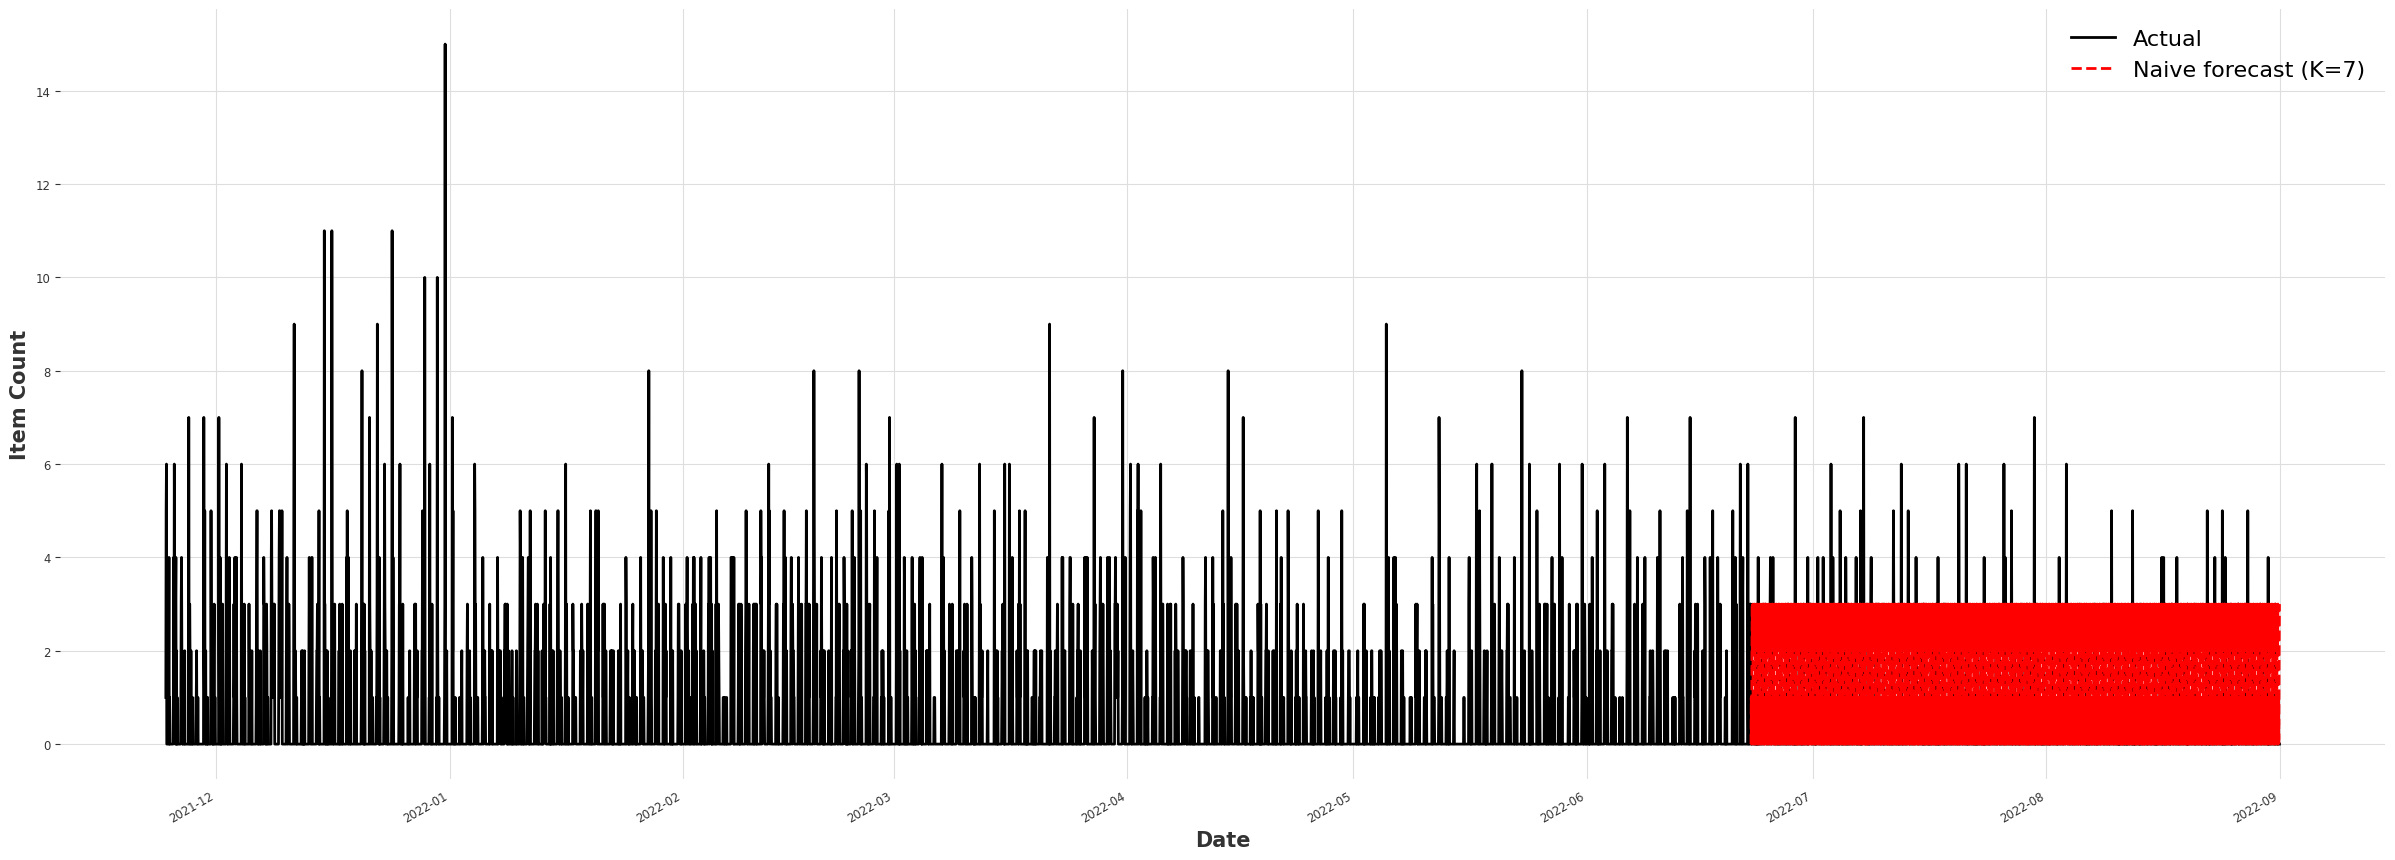

In [67]:
naive_model = NaiveSeasonal(K=7)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

fig = plt.figure(figsize=(30,10))   
series.plot(label="actual",linestyle = '-', color = 'black')
naive_forecast.plot(label="naive forecast (K=7)",linestyle = '--', color = 'red')
plt.legend(loc=0, prop={'size': 16},labels= ['Actual','Naive forecast (K=7)'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)


In [68]:
print("naive model {} MASE: {:.2f}".format(naive_model, mase(val, naive_forecast, train)))

naive model Naive seasonal model, with K=7 MASE: 1.95


Text(0, 0.5, 'Item Count')

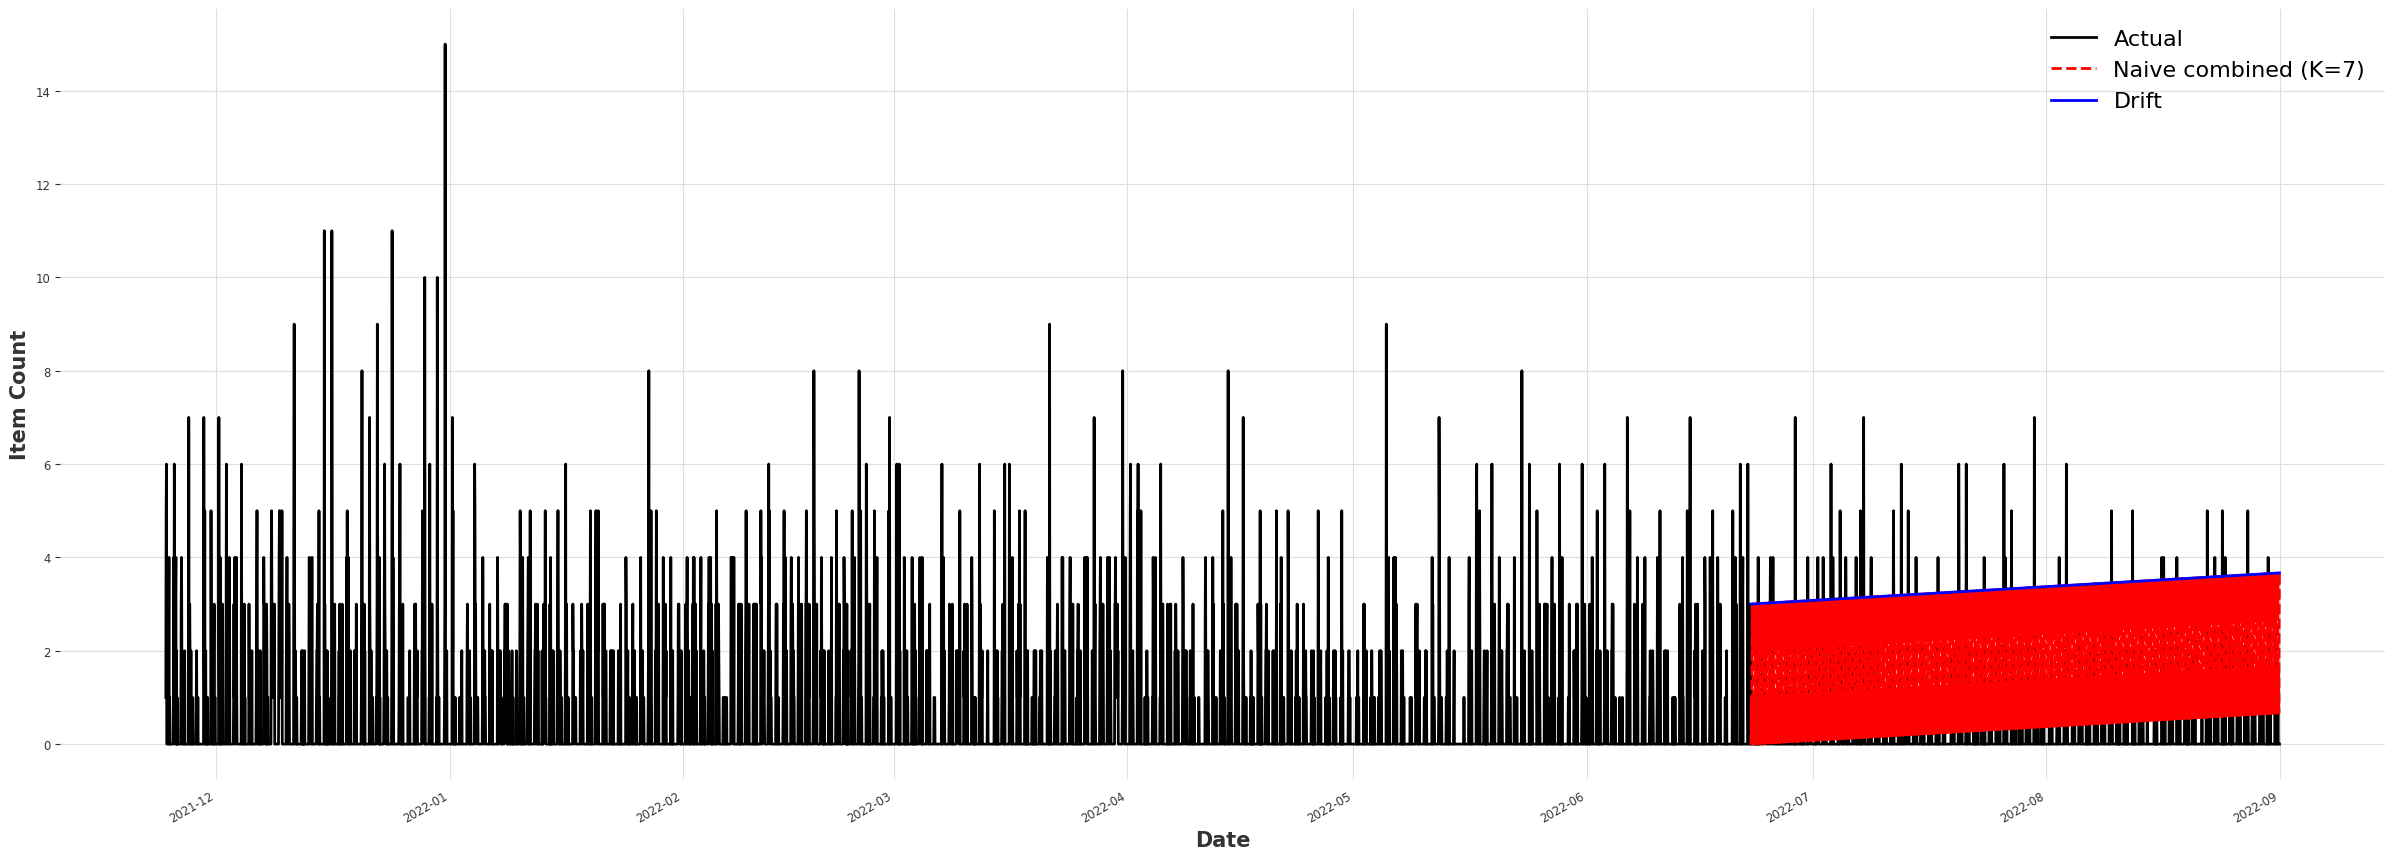

In [69]:
from darts.models import NaiveDrift

naive_drift_model = NaiveDrift()
naive_drift_model.fit(train)
naive_drift_forecast = naive_drift_model.predict(len(val))

naive_combined_forecast = naive_drift_forecast + naive_forecast - train.last_value()



# fig = plt.figure(figsize=(30,10))  
# series.plot()
# naive_combined_forecast.plot(label="combined")
# naive_drift_forecast.plot(label="drift")

fig = plt.figure(figsize=(30,10))   
series.plot(label="actual",linestyle = '-', color = 'black')
naive_combined_forecast.plot(label="naive combined forecast (K=7)",linestyle = '--', color = 'red')
naive_drift_forecast.plot(label="drift",linestyle = '-', color = 'blue')
plt.legend(loc=0, prop={'size': 16},labels= ['Actual','Naive combined (K=7)', 'Drift'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)

In [70]:
print("naive model {} MASE: {:.2f}".format(naive_drift_model, mase(val, naive_combined_forecast,train)))

naive model Naive drift model MASE: 2.28


In [71]:
def eval_model(model,series,train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    #print("model {} MAPE: {:.2f}%".format(model, mape(val, forecast)))
    print("model {} MASE: {:.2f}.".format(model,mase(val,forecast,train)))
    #print("model {} OPE: {:.2f}.".format(model,ope(val, forecast)))
    print("model {} R2: {:.2f}.".format(model,r2_score(val, forecast)))

    fig, ax = plt.subplots(2,figsize=(15, 7.5))
    cycler = plt.cycler(linestyle=['-', '--',], color=['black', 'red'])
    #ax = fig.add_subplot()
    ax[0].set_prop_cycle(cycler)
    ax[1].set_prop_cycle(cycler)

    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        label.set_fontsize(18)

    #plt.figure(figsize=(30, 5))
    series.plot(label="Actual", ax = ax[0])
    #val.plot(label="Validation", ax = ax[0])
    forecast.plot(label="Forecast", ax=ax[0])
    ax[0].legend(loc='upper right')
    #plt.show()

    for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(18)

    #plt.figure(figsize=(30, 5))
    val.plot(label="Validation", ax = ax[1])
    forecast.plot(label="Forecast", ax=ax[1])
    ax[1].legend(loc='upper right')
    ax[1].set_xlim(val.pd_dataframe().index[0], val.pd_dataframe().index[-1])
    #ax[1].set_ylim(0, 0.4)
    #plt.show()


    return model, forecast



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24 MASE: 0.69.
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24 R2: 0.10.


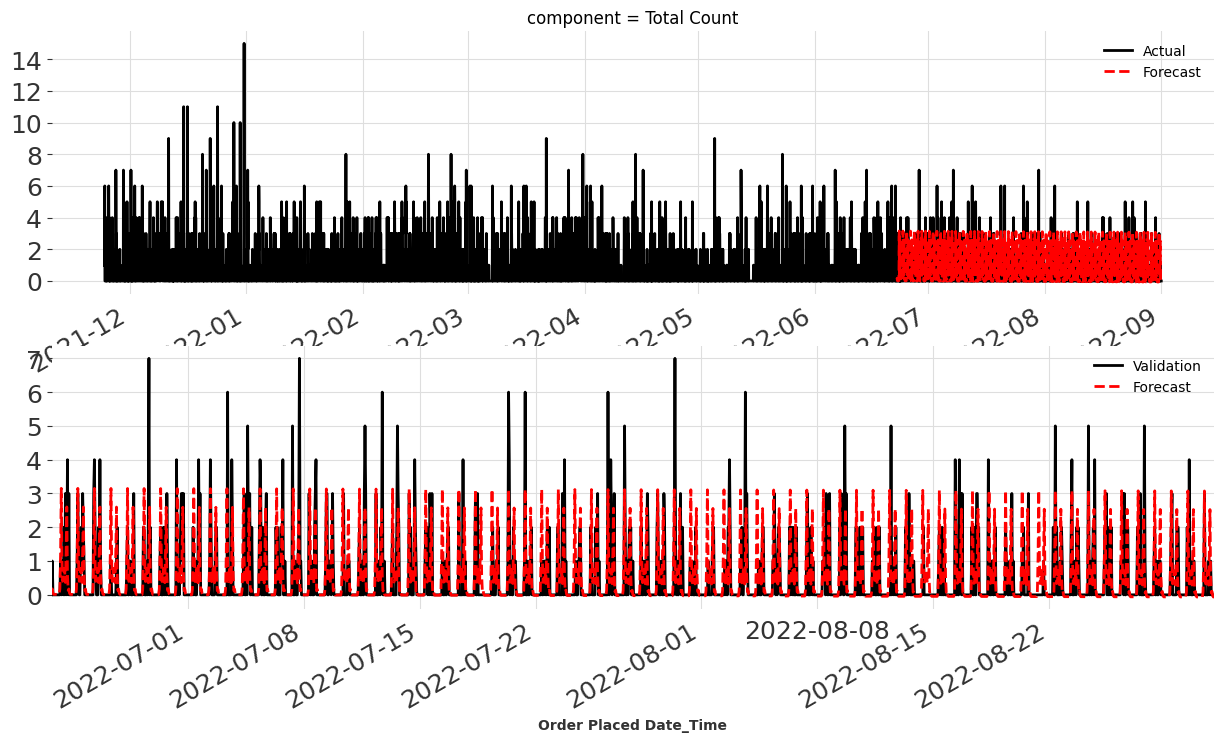

In [80]:
ES, forecast = eval_model(ExponentialSmoothing(),series,train,val)
#TBATS, forecast = eval_model(TBATS(),series,train,val)
#AR, forecast = eval_model(AutoARIMA(),series,train,val)
#TH, forecast = eval_model(Theta(),series,train,val)

In [23]:
# # Search for the best theta parameter, by trying 50 different values
# thetas = 2 - np.linspace(-10, 10, 100)

# best_mape = float("inf")
# best_theta = 0

# for theta in thetas:
#     model = Theta(theta)
#     model.fit(train)
#     pred_theta = model.predict(len(val))
#     res = mape(val, pred_theta)

#     if res < best_mape:
#         best_mape = res
#         best_theta = theta

In [24]:
# best_theta_model = Theta(best_theta)
# best_theta_model.fit(train)
# pred_best_theta = best_theta_model.predict(len(val))

# print(
#     "The MAPE is: {:.2f}, with theta = {}.".format(
#         mape(val, pred_best_theta), best_theta
#     )
# )

In [25]:
# historical_fcast = ES.historical_forecasts(
#     series, start=0.6, forecast_horizon=2000, verbose=True
# )

# series.plot(label="data")
# historical_fcast.plot(label="backtest 3-months ahead forecast (Theta)")
# print("MASE = {:.2f}%".format(mase(historical_fcast, series)))

In [26]:
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

In [27]:
#series_scaled = series

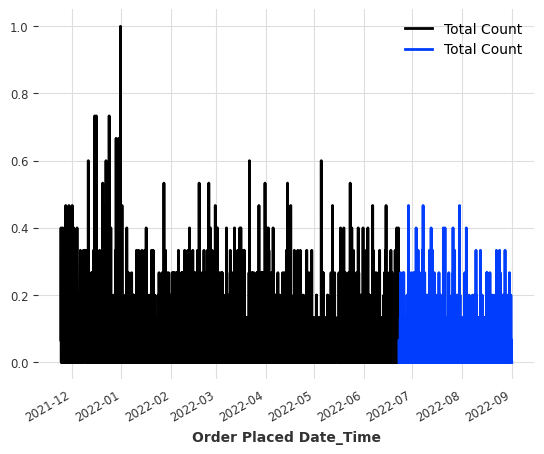

In [28]:
train, val = series_scaled.split_before(0.75)
train.plot()
val.plot()

In [29]:
# prediction.pd_dataframe()['Total Count'].sort_values(ascending=True)
# prediction = prediction.pd_dataframe()
# prediction[prediction['Total Count'] <= 0] = 0
# prediction = prediction.round(2)
# prediction = TimeSeries.from_dataframe(prediction)

In [30]:
#NB, forecast  = eval_model(NBEATSModel(input_chunk_length=672, output_chunk_length=168, n_epochs=20, random_state=0),series_scaled,train,val)

<AxesSubplot: xlabel='Order Placed Date_Time'>

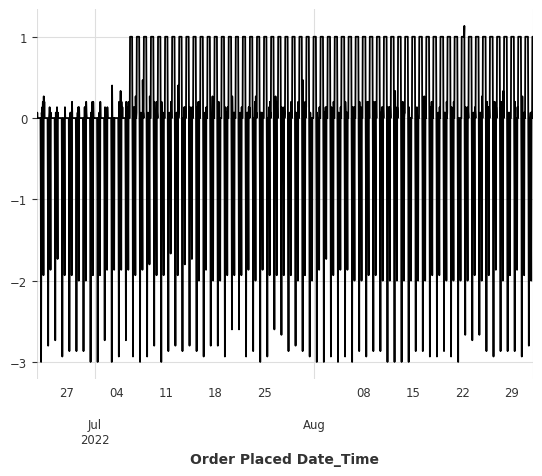

In [31]:
f = forecast.pd_dataframe()
f = f.apply(np.floor)
v = val.pd_dataframe()
d = v['Total Count'] - f['Total Count']
d.plot()

In [32]:
def epoch_hpt(ephs):
    model = NBEATSModel(input_chunk_length=672, output_chunk_length=168, n_epochs=20, random_state=0)
    model.fit(train, verbose = False)
    forecast = model.predict(len(val))
    mase_err = mase(val, forecast, train)
    return ephs, mase_err

In [33]:
# ephs_lst = []
# mase_err_lst = []
# for i in range(1,100):
#     print(i)
#     ephs, mape_err = epoch_hpt(i)
#     ephs_lst.append(ephs)
#     mase_err_lst.append(mape_err)

In [34]:
# hpt = pd.DataFrame.from_dict({'ephs': ephs_lst, 'mase': mase_err_lst})
# hpt.plot(x = 'ephs', y = 'mase')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]

model <darts.models.forecasting.tft_model.TFTModel object at 0x0000020EA0DA3C70> MASE: 1.50.
model <darts.models.forecasting.tft_model.TFTModel object at 0x0000020EA0DA3C70> R2: -2.53.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


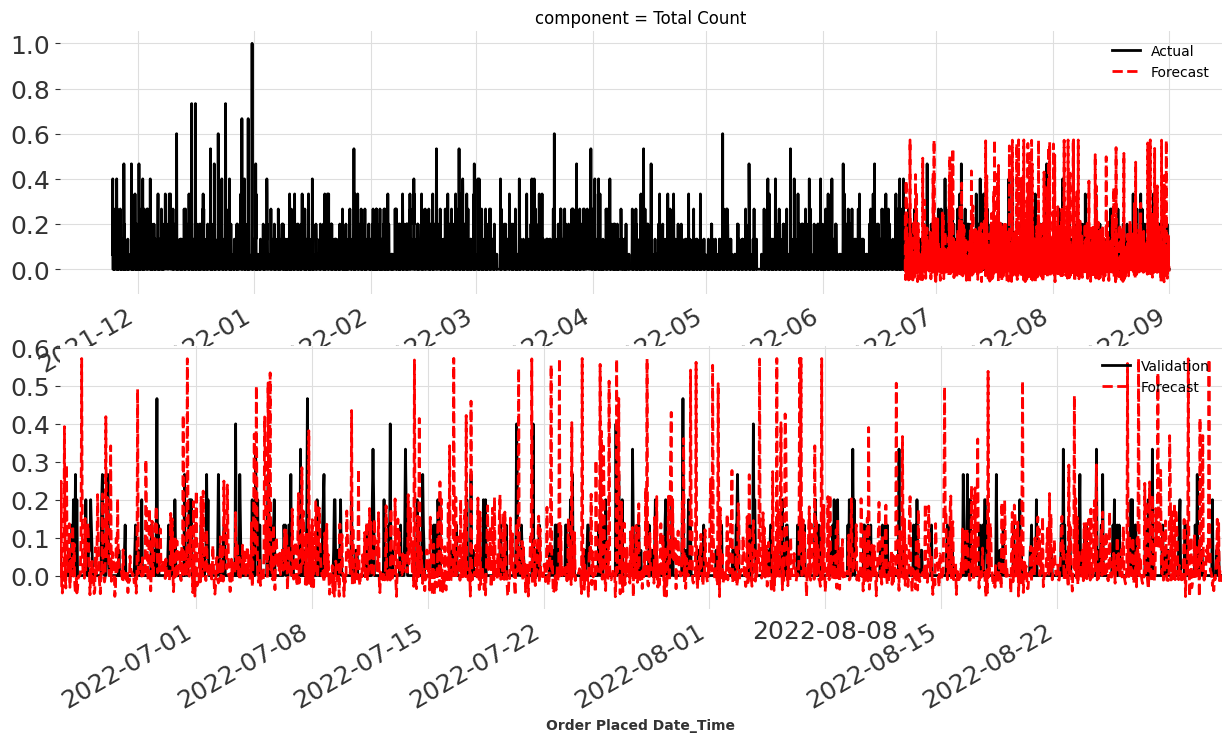

In [35]:
TFT, forecast_TFT  = eval_model(TFTModel(input_chunk_length=672, output_chunk_length=168, n_epochs=100, random_state=0,add_relative_index = True),series_scaled,train,val)

## Ensemble

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model <darts.models.forecasting.baselines.NaiveEnsembleModel object at 0x0000020EA4BAF700> MASE: 2.15.
model <darts.models.forecasting.baselines.NaiveEnsembleModel object at 0x0000020EA4BAF700> R2: -2.03.


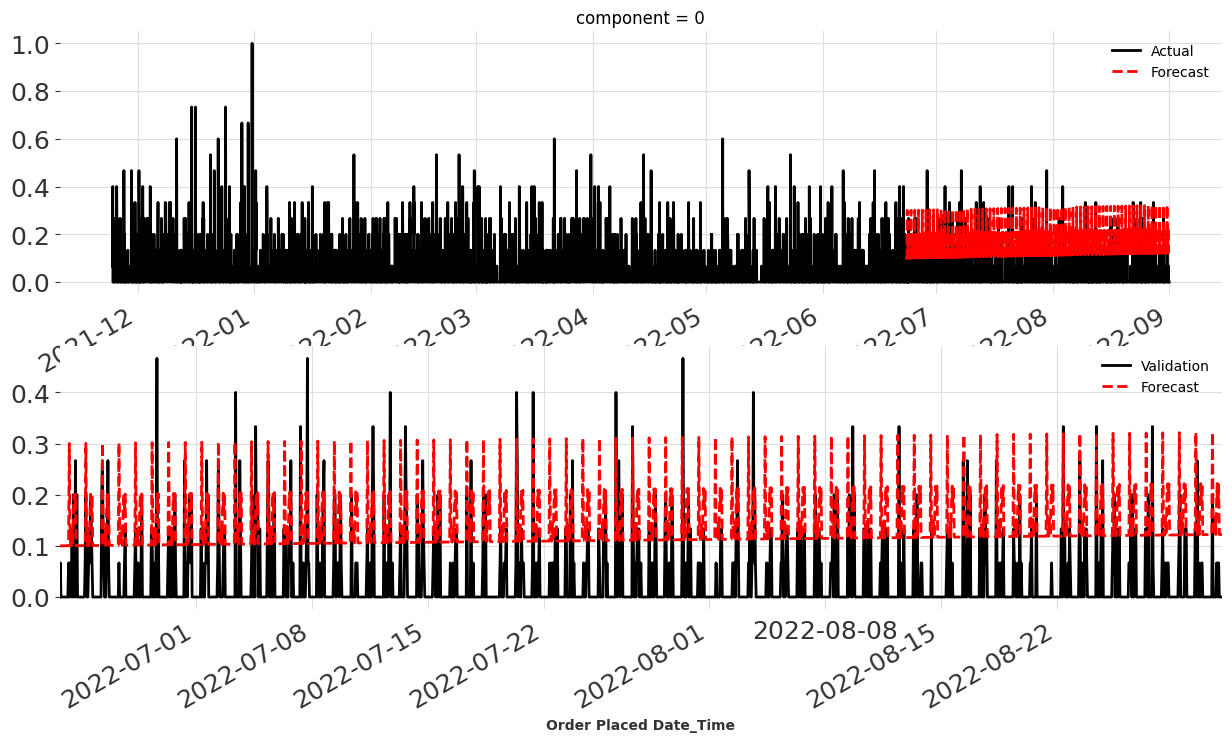

In [42]:
from darts.models import NaiveEnsembleModel
models = [ExponentialSmoothing(), NBEATSModel]
ensemble_model = NaiveEnsembleModel(models=models)
ensemble, forecast_en  = eval_model(ensemble_model,series_scaled,train,val)

In [47]:
from darts.models import RegressionEnsembleModel

models = [ExponentialSmoothing(), NBEATSModel(input_chunk_length=672, output_chunk_length=168, n_epochs=20, random_state=0), TFTModel(input_chunk_length=672, output_chunk_length=168, n_epochs=20, random_state=0)]

ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=12)
ensemble, forecast_en  = eval_model(ensemble_model,series_scaled,train,val)

ValueError: All models must either be GlobalForecastingModel instances, or none of them should be.


ValueError: All models must either be GlobalForecastingModel instances, or none of them should be.